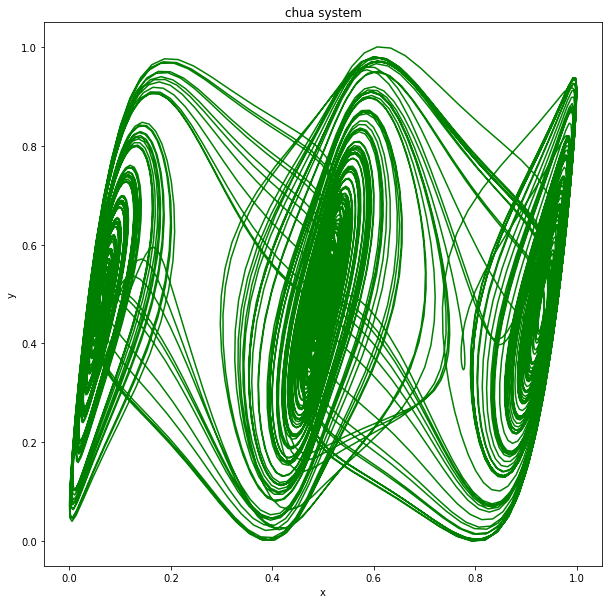

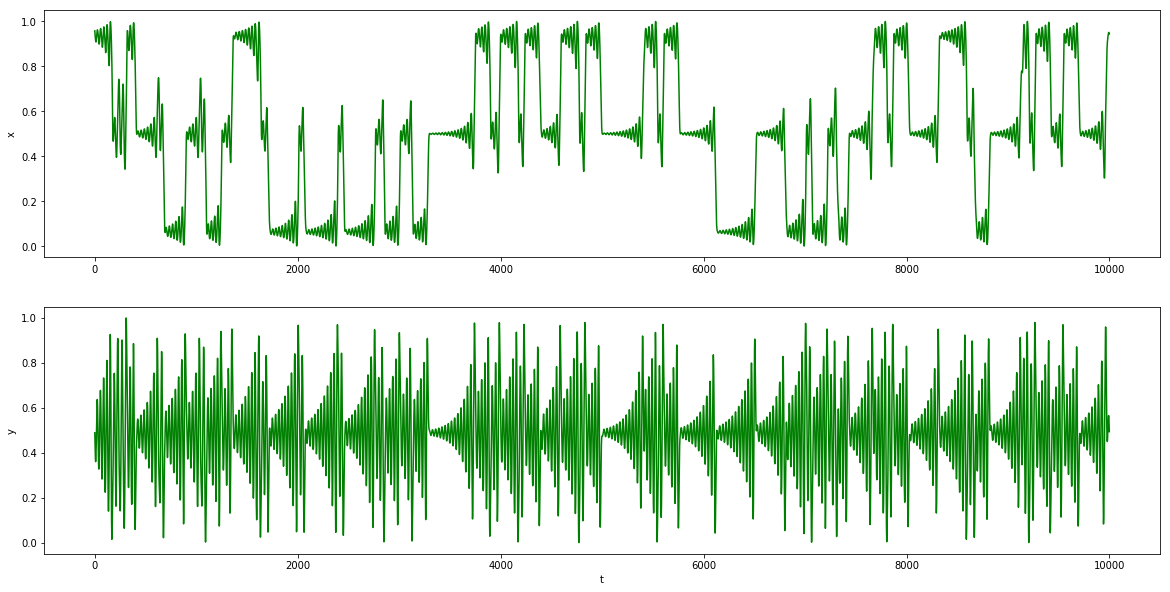

In [537]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from dataset.chaotic_system import gen_model, trajectory
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import numba
from math import *



names = [
#     'rossler',
#     'rabinovich_fabrikant',
#     'lorentz',
#     'chen',
    'chua',
#     'switch'
]

horizon = 30
N = 10000
n = 5  # 使用 n 个历史点作为输入
n_dim = 2
N_h = 200
num_train = 2000
train_start = 0
num_test = 2000
test_start = 4000
np.random.seed()


system_name = names[0]


functions, start_point, step = gen_model(system_name)
data = trajectory(functions, start_point, N, step)
data = rescale(data[:n_dim])


def show_dateset():
    fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')
    plt.plot(*data, 'g')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(system_name + ' system')
    # plt.savefig('../figures/' + system_name + '_system.pdf')
    plt.show()

    plt.figure(figsize=(20, 10))
    plt.title(system_name)
    dim = ['x', 'y', 'z']
    for i in range(n_dim):
        plt.subplot(n_dim, 1, i + 1)
        plt.plot(data[i, :].T, color='g')
        plt.ylabel(dim[i])
#         plt.legend(loc='upper right')
    plt.xlabel('t')
    plt.show()

show_dateset()

In [538]:
x_train = np.vstack([select_samples(data, train_start + i, num_train) for i in range(n)])
y_train = select_samples(data, train_start + n, num_train)

x_test = np.vstack([select_samples(data, test_start + i, num_test) for i in range(n)])  # test set
y_test = select_samples(data, test_start + n, num_test)

print('train set:', x_train.shape, y_train.shape)
print('test  set:', x_test.shape, y_test.shape)

W_i, sigmas = fcm(x_train.T, N_h)

train set: (10, 2000) (2, 2000)
test  set: (10, 2000) (2, 2000)


In [539]:
import torch, random
import torch.nn as nn
import torch.optim as optim
from RBFNN import RBFNN

torch.manual_seed(777)


class TorchRBFNN(nn.Module):
    def __init__(self, centers, n_out=10):
        super(TorchRBFNN, self).__init__()
        self.n_out = n_out
        self.n_in = centers.size(1)
        self.num_centers = centers.size(0)

        self.centers = nn.Parameter(centers, requires_grad = False)
        self.beta = nn.Parameter(torch.ones(1,self.num_centers)*1, requires_grad = True)
        self.W_out = nn.Parameter(torch.randn(self.num_centers, self.n_out)*0.02)
#         self.W_out = nn.Parameter(torch.randn(self.num_centers + self.n_in, self.n_out)*0.02)
        self.bias = nn.Parameter(torch.randn(1, self.n_out)*0.02)


    def kernel_fun(self, batches):
        n_input = batches.size(0) # number of inputs
        A = self.centers.view(self.num_centers,-1).repeat(n_input,1,1)  # shape: (n_input, n_center, n_dim)
        B = batches.view(n_input,-1).unsqueeze(1).repeat(1,self.num_centers,1) # shape: (n_input, n_center, n_dim)
        C = torch.exp(-self.beta.mul((B-A).pow(2).sum(2,keepdim=False)))  # shape: (n_input, n_center)
        return C

    def forward(self, batches):
        radial_val = self.kernel_fun(batches)
#         out = torch.cat([radial_val, batches], dim=1).mm(self.W_out) + self.bias
        out = torch.cat([radial_val], dim=1).mm(self.W_out) + self.bias
        return out
    
    def print_network(self):
        num_params = 0
        for param in self.parameters():
            num_params += param.numel()
            print(param.numel())
        print(self)
        print('Total number of parameters: %d' % num_params)


class RBFN_TS(object):
    def __init__(self, args):
        self.max_epoch = args.epoch
        self.trainset = args.dataset[0]
        self.testset = args.dataset[1]
        self.model_name = args.model_name
        self.device = 'cuda:0' if args.cuda else 'cpu'
        self.lr = args.lr
        self.n_in = args.n_in
        self.n_out = args.n_out
        self.num_centers = args.num_centers
#         self.center_id = np.random.choice(len(self.trainset[0]),self.num_centers,replace=False)
#         self.center_id = np.array([i*(len(self.trainset[0])//self.num_centers) for i in range(self.num_centers)])
#         self.centers = torch.from_numpy(self.trainset[0][self.center_id]).float()
#         self.centers = torch.rand(self.num_centers,self.n_in)*2-0.5
        from utils import fcm
        W_i, sigmas = fcm(self.trainset[0], self.num_centers)
        self.centers = torch.from_numpy(W_i).float()
        self.sigmas = sigmas
#         self.sigmas = np.array([1]*self.num_centers)
        self.model = TorchRBFNN(self.centers, n_out=self.n_out).to(self.device)

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        self.loss_fun = nn.MSELoss()

    def train(self, epoch=1,  finetune=False):
        self.model.to(self.device)
        conf_dict = dict(
            N_h=self.num_centers,
            skip_con=0,
            reweight=None,
            sigma = 1,
            centers=(self.centers.numpy(), self.sigmas)
        )
        model = RBFNN(**conf_dict)
        model.train(self.trainset[0].T, self.trainset[1].T)
#         y_pred = model.predict(self.testset[0].T)
#         def mse(a, b):
#             return np.average(np.square(a-b))
#         print('mse:', mse(y_pred, self.testset[1].T))

        self.model.centers.data = torch.from_numpy(model.W_i).float().to(self.device)
        self.model.W_out.data = torch.from_numpy(model.W_o[:,:-1].T).float().to(self.device)
        self.model.bias.data = torch.from_numpy(model.W_o[:,-1:].T).float().to(self.device)
        self.model.beta.data = 0.5/torch.from_numpy(self.sigmas).view(1,-1).float().to(self.device)
        
        record = []
        record.append(self.model.centers[0].detach().cpu().numpy().copy())
        if finetune:
            self.model.train()
            for epoch in range(min(epoch,self.max_epoch)):
                
                avg_cost = 0

                X = torch.from_numpy(self.trainset[0]).float().to(self.device)
                Y = torch.from_numpy(self.trainset[1]).float().to(self.device)        # label is not one-hot encoded

                self.optimizer.zero_grad()             
                Y_prediction = self.model(X)         
                cost = self.loss_fun(Y_prediction, Y) 
                cost.backward(retain_graph=True)                   
                self.optimizer.step()                  
                if epoch % 100 == 0:
                    print("[Epoch: {:>4}] cost = {:>.9}".format( epoch + 1, np.sqrt(cost.item()) ))
                record.append(self.model.centers[0].detach().cpu().numpy().copy())
            print(" [*] Training finished!")
        return record

    def test(self):
        self.model.eval()
        X = torch.from_numpy(self.testset[0]).float().to(self.device)
        Y = torch.from_numpy(self.testset[1]).float().to(self.device)        # label is not one-hot encoded

        with torch.no_grad():             # Zero Gradient Container
            Y_prediction = self.model(X)         # Forward Propagation
            cost = self.loss_fun(Y_prediction, Y)

            print('Accuracy of the network on test data: %g' % np.sqrt(cost.item()))
            print(" [*] Testing finished!")



class Dict(dict):
    __setattr__ = dict.__setitem__
    __getattr__ = dict.__getitem__


args = Dict(
    lr = 1e-3,
    epoch = 10000,
    n_in = n_dim*n,
    n_out = n_dim,
    num_centers = N_h,
    save_dir = 'ckpoints',
    result_dir = 'outs',
    dataset = [(x_train.T, y_train.T), (x_test.T, y_test.T)],
    model_name='RBFN',
    cuda=True
)
rbfn = RBFN_TS(args)
rbfn.model.print_network()
print(rbfn.model.beta)

2000
200
400
2
TorchRBFNN()
Total number of parameters: 2602
Parameter containing:
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], device=

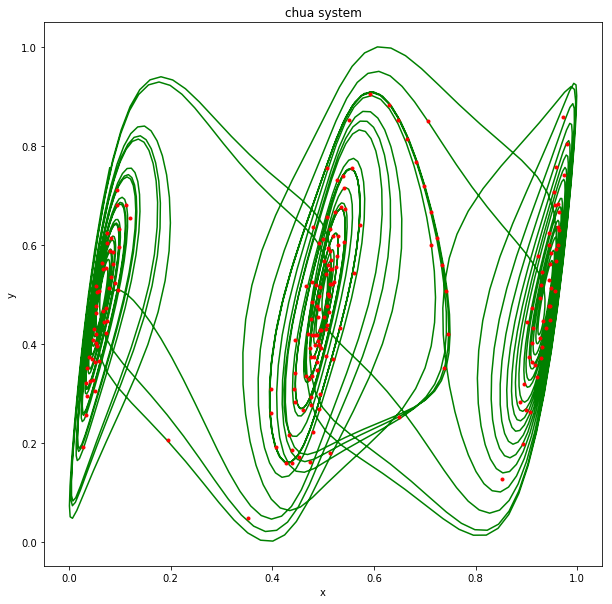

Accuracy of the network on test data: 0.00131054
 [*] Testing finished!


In [540]:
def show_centers(rbfn):
    fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')
    plt.plot(*x_train[:n_dim], 'g')
    plt.plot(*rbfn.model.centers[:,:n_dim].detach().cpu().numpy().T, 'r.')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(system_name + ' system')
    plt.show()

show_centers(rbfn)
rec = rbfn.train()
b0 = rbfn.model.beta.data
rbfn.test()

In [541]:
rbfn.train()
rbfn.test()
rbfn.model.centers.requires_grad_(True)
rbfn.model.W_out.requires_grad_(True)
rbfn.model.bias.requires_grad_(True)
rbfn.model.beta.requires_grad_(True)
# rec = rbfn.train(2000, finetune=True)
rbfn.test()
print(rbfn.model.beta)

Accuracy of the network on test data: 0.00131054
 [*] Testing finished!
Accuracy of the network on test data: 0.00131054
 [*] Testing finished!
Parameter containing:
tensor([[1.3505, 1.6038, 1.4457, 2.0568, 1.4056, 1.8479, 1.4104, 1.4871, 2.3726,
         1.5879, 1.5013, 1.8623, 1.6537, 2.5634, 1.3808, 0.9669, 1.6538, 1.7764,
         2.6425, 1.9894, 2.1447, 1.5942, 2.2372, 1.3334, 1.7341, 1.8949, 2.0697,
         1.5537, 1.8068, 2.0703, 1.5524, 1.4725, 2.1591, 2.5767, 2.4282, 2.6432,
         1.8189, 2.2098, 1.7948, 1.3782, 2.4811, 2.1305, 2.1157, 1.5039, 2.0322,
         1.5841, 1.7815, 1.5122, 2.4096, 2.4958, 2.1720, 1.9975, 1.4557, 1.4396,
         1.5095, 1.7183, 1.5378, 1.8689, 2.1045, 1.7042, 1.8168, 1.4672, 1.5260,
         1.4319, 2.0137, 2.1562, 1.6363, 2.2960, 2.0101, 2.3163, 1.4625, 1.9200,
         1.9656, 2.3477, 2.5336, 2.2335, 2.0480, 2.0464, 2.3634, 1.9701, 1.6741,
         1.3807, 1.6314, 1.7962, 1.7361, 2.0090, 1.8626, 1.6703, 1.6468, 1.8242,
         1.5539, 2.3024,

In [542]:
print(rbfn.model.beta.data/b0)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]], device='cuda:0')


(60, 2000)


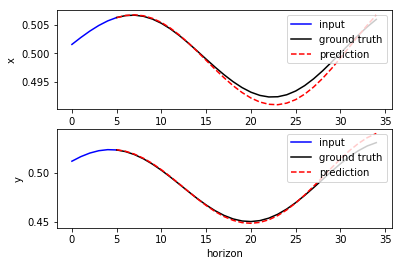

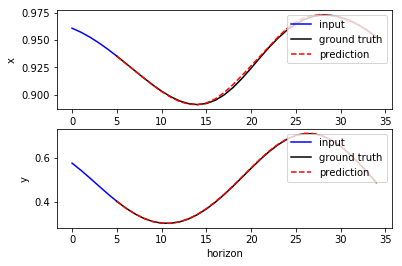

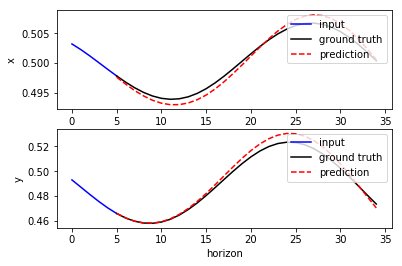

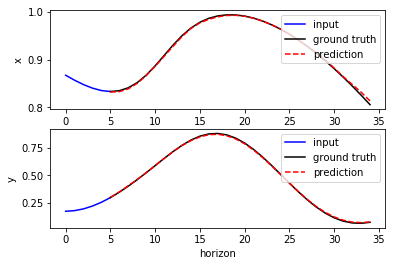

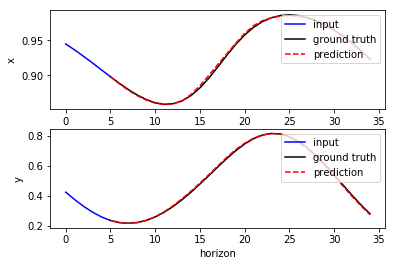

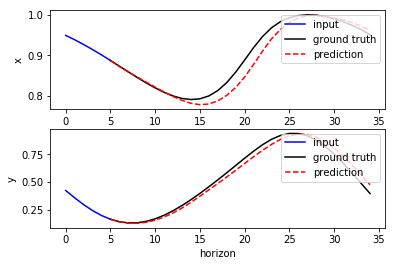

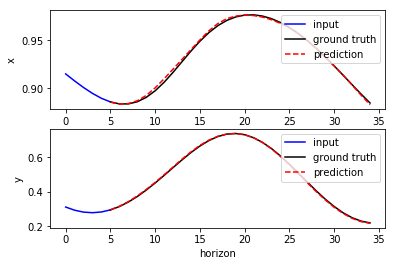

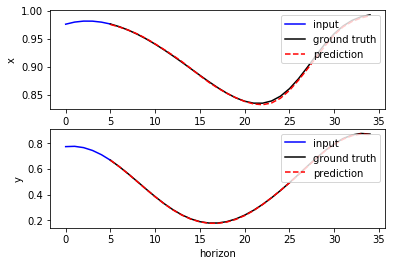

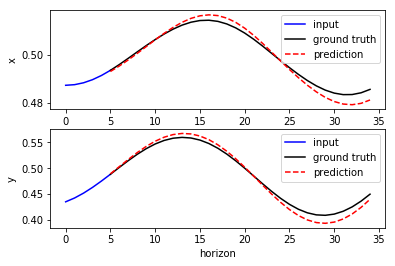

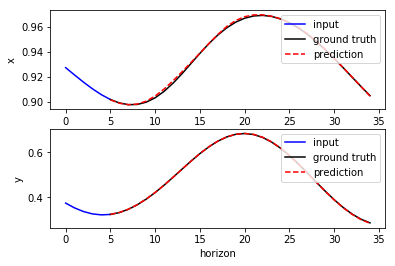

In [552]:
horizon = 30
Y_true = np.vstack([select_samples(data, test_start + n + i, num_test) for i in range(horizon)])
print(Y_true.shape)



with torch.no_grad():
    for i in np.random.choice(len(x_test.T),10,replace=False):
        x = torch.from_numpy(x_test.T[i:i+1]).float()
        pred = []
        rbfn.model.cpu()
        for _ in range(Y_true.shape[0]//n_dim):
            y = rbfn.model(x)
            x = torch.from_numpy(np.hstack([x[:,n_dim:],y]))
            pred.append(y.numpy()[0])
        pred = np.hstack(pred)
        
        A = pred
        B = Y_true[:,i:i+1]
        X = np.vstack((x_test[:,i:i+1],B[:n_dim]))
        plt.figure()
        ylabel = ['x','y','z']
        for j in range(n_dim):
            plt.subplot(n_dim,1,j+1)
            plt.plot(range(n+1),X[j::n_dim], 'b', label='input')
            plt.plot(range(n, n+horizon),B[j::n_dim], 'k',label='ground truth')
            plt.plot(range(n, n+horizon),A[j::n_dim], 'r--',label='prediction')
            plt.ylabel(ylabel[j])
            plt.legend(loc='upper right')
        plt.xlabel('horizon')
        plt.show()

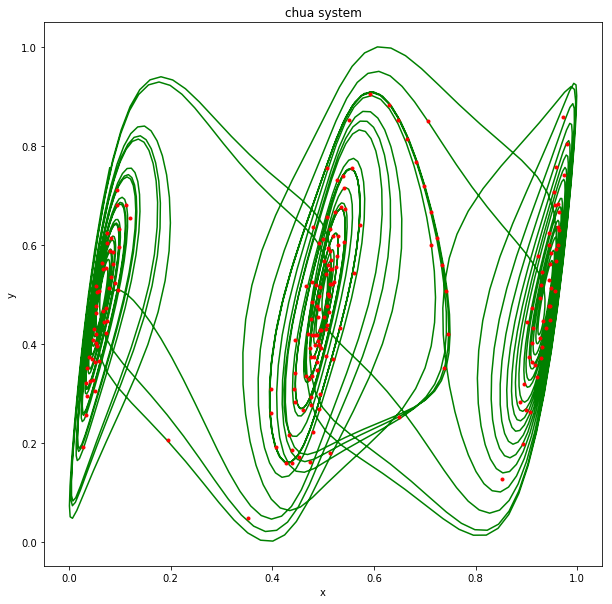

In [544]:

def show_centers(rbfn):
    fig = plt.figure(figsize=(10, 10))
#     ax = fig.add_subplot(111, projection='3d')
    plt.plot(*x_train[:n_dim], 'g')
    plt.plot(*rbfn.model.centers[:,:n_dim].detach().cpu().numpy().T, 'r.')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(system_name + ' system')
    # plt.savefig('../figures/' + system_name + '_system.pdf')
    plt.show()

show_centers(rbfn)
# for i in range(10):
#     plt.figure()
#     plt.plot(rbfn.model.centers[i,::3].detach().numpy())
# #     plt.plot(x_train.T[i,::3])
#     plt.show()

1


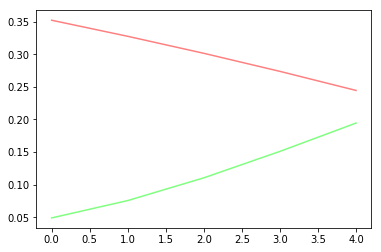

In [545]:
def interpolateColor(colorA, colorB, alpha):
    return tuple(np.array(colorA)*(1-alpha) + np.array(colorB)*alpha)

red = (1,0,0)
white = (1,1,1)
pink = interpolateColor(white, red, 0.5)
green = (0,1,0)
white = (1,1,1)
wgreen = interpolateColor(white, green, 0.5)
blue = (0,0,1)
white = (1,1,1)
wblue = interpolateColor(white, blue, 0.2)
print(len(rec))
for i in range(len(rec)):
    plt.plot(range(n),np.squeeze(rec[i].reshape(-1,n_dim).T[0]), color=interpolateColor(pink, red, i/len(rec))+(1,))
    plt.plot(range(n),np.squeeze(rec[i].reshape(-1,n_dim).T[1]), color=interpolateColor(wgreen, green, i/len(rec))+(1,))
#     plt.plot(range(n),np.squeeze(rec[i].reshape(-1,n_dim).T[2]), color=interpolateColor(wblue, blue, i/len(rec))+(1,))
plt.show()